In [23]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the training and test datasets
train_data = pd.read_csv('../data/gold_data_train.csv')
test_data = pd.read_csv('../data/gold_data_test.csv')

# Split features (X) and target (y)
X_train = train_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y_train = train_data['Close']

X_test = test_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y_test = test_data['Close']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(3008, 6) (3008,) (752, 6) (752,)


In [3]:
# Create dictionaries to store models and their performance metrics
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Dictionary to store evaluation results
results = {}


In [4]:
# Train each model and evaluate it
for model_name, model in models.items():
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Save metrics
    results[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Create a DataFrame to visualize the results
results_df = pd.DataFrame(results).T
print(results_df)


                            MAE           MSE          RMSE        R2
Linear Regression  4.910304e-13  6.165355e-25  7.851978e-13  1.000000
Decision Tree      7.167516e-01  5.605080e+00  2.367505e+00  0.999954
Random Forest      5.060733e-01  2.487579e+00  1.577206e+00  0.999980
Gradient Boosting  2.182036e+00  1.305527e+01  3.613207e+00  0.999893
XGBoost            2.017186e+00  2.157339e+01  4.644716e+00  0.999824


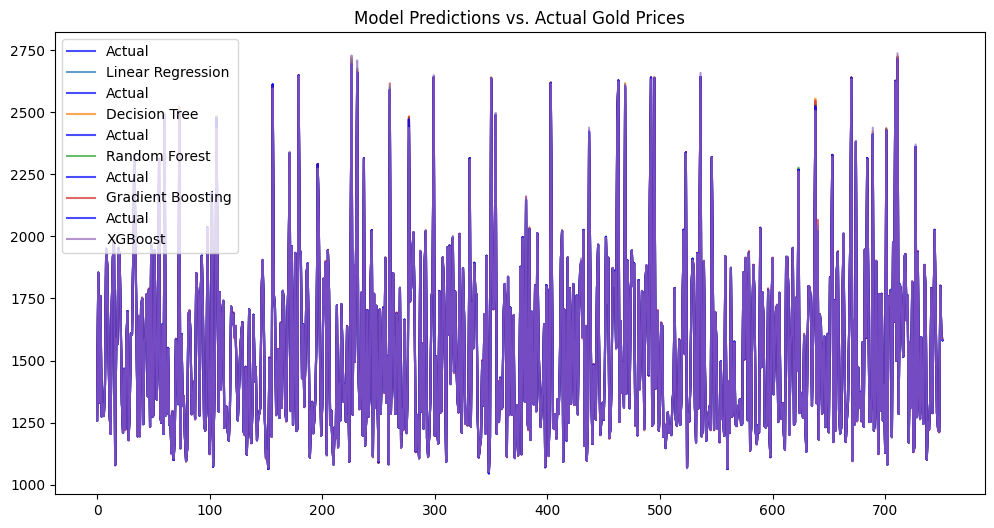

In [5]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    plt.plot(y_test.values, label=f"Actual", color='blue', alpha=0.7)
    plt.plot(y_pred, label=f"{model_name}", alpha=0.7)

plt.title('Model Predictions vs. Actual Gold Prices')
plt.legend()
plt.show()


In [25]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])
test_data_scaled = scaler.transform(test_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])# Create sequences of 60 time-steps
x_train = []
y_train = []

for i in range(60, len(train_data_scaled)):
    x_train.append(train_data_scaled[i-60:i])  # 60 timesteps with all 6 features
    y_train.append(train_data_scaled[i, 3])      # Predict 'Close' price

# Convert to NumPy arrays and reshape for LSTM
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 60, 6))  # [samples, timesteps, features]

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Define the LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60, 6)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

# Train the LSTM model
model_lstm.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

# Prepare test data for LSTM prediction
x_test = []
y_test = []

for i in range(60, len(test_data_scaled)):
    x_test.append(test_data_scaled[i-60:i])
    y_test.append(test_data_scaled[i, 3])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 6))

# Predict using the LSTM model
y_pred_lstm = model_lstm.predict(x_test)

# Evaluate the LSTM model performance
lstm_mae = mean_absolute_error(y_test, y_pred_lstm)
lstm_mse = mean_squared_error(y_test, y_pred_lstm)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, y_pred_lstm)

print(f"LSTM Model Performance: MAE={lstm_mae}, RMSE={lstm_rmse}, R2={lstm_r2}")


x_train shape: (2948, 60, 6)
y_train shape: (2948,)
Epoch 1/50


C:\Users\henta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1730
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1725
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1654
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1639
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1627
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1730
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1621
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1652
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1633
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1618
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1635
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1652
Epoch 13/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1598
Epoch 14/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1677
Epoch 15/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1664
Epoch 16/50
93/